# COMP551: Project 3

#### Group 47
#### Authors : Ying Sun, Said Khalifef & Boury Mbodj
#### Date : March 16th 2019
#### Subject: The given file contains the implementation of a vgg16 supervised classification model using pytorch. 

In [0]:
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader, Dataset, TensorDataset

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
!ls "/content/drive/My Drive/COMP551P3/comp-551-w2019-project-3-modified-mnist"

Model		Project3_model.ipynb   test_images.pkl	 vgg19_bn.ipynb
P3resnet.ipynb	Project3_model.py      train_images.pkl
P3trial2.ipynb	sample_submission.csv  train_labels.csv
P3trial4.ipynb	solution_final3.csv    Untitled.ipynb


In [0]:
f=open("/content/drive/My Drive/COMP551P3/comp-551-w2019-project-3-modified-mnist/train_images.pkl","rb")
f1=open("/content/drive/My Drive/COMP551P3/comp-551-w2019-project-3-modified-mnist/train_labels.csv","rb")
f2=open("/content/drive/My Drive/COMP551P3/comp-551-w2019-project-3-modified-mnist/test_images.pkl","rb")

In [0]:
#read training data through pandas
x_train=pd.read_pickle(f)
#normalize training data by toTensor and mean(0.5) and std(0.5). 
#Note that torchvision.transforms can be used. But I'm still not familiar with it...
x_train=(x_train/255-0.5)*2
#read training lable, the first column in y_train_r is id num, the second column is lable.
y_train_r = pd.read_csv(f1)
#tranfer numpy to tensor, in order to use gpu
y_train=torch.tensor(y_train_r.values[:,1])
#product train set.
trainset=[np.zeros((64,64)),np.zeros(1)]
for j in range(36000): #Note this part all data in train_images.pkl is load into trainset.
    # If valid set is needed, 40000 can be modifoed as the required length of trainset
    # Then do the same thing to validset, but the range need to be after trainset
    trainset.append([x_train[j],y_train[j]])
del trainset[0]
del trainset[0]
#copy 1 channel as 3 channels
# Use validation set 
validset=[np.zeros((64,64)),np.zeros(1)]
for j in range(40000): #Note this part all data in train_images.pkl is load into trainset.
    # If valid set is needed, 40000 can be modifoed as the required length of trainset
    # Then do the same thing to validset, but the range need to be after trainset
    if (j>36000):
       validset.append([x_train[j],y_train[j]])
del validset[0]
del validset[0]
#copy 1 channel as 3 channels 
for i in range(len(trainset)):
    trainset[i][0]=torch.tensor([np.array(trainset[i][0]),np.array(trainset[i][0]),np.array(trainset[i][0])])
#Get trainloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
#copy 1 channel as 3 channels 
for i in range(len(validset)):
    validset[i][0]=torch.tensor([np.array(validset[i][0]),np.array(validset[i][0]),np.array(validset[i][0])])
#Get validloader
validloader = torch.utils.data.DataLoader(validset, batch_size=4,
                                          shuffle=False, num_workers=2)

In [0]:
# Preprocessing testset:
x_test=pd.read_pickle(f2)
x_test=(x_test/255-0.5)*2
testset=[np.zeros((64,64)),np.zeros(1)]
for j in range(len(x_test)):
    testset.append([x_test[j],y_train[j]])
del testset[0]
del testset[0]
for i in range(len(testset)):
    testset[i][0]=torch.tensor([np.array(testset[i][0]),np.array(testset[i][0]),np.array(testset[i][0])])
#preporcessing testloader
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                          shuffle=False, num_workers=2)

In [0]:
print('[Train  and validation size]')
print(' - Numpy Shape:', x_train.shape)
print('[Test size]')
print(' - Numpy Shape:', x_test.shape)




[Train  and validation size]
 - Numpy Shape: (40000, 64, 64)
[Test size]
 - Numpy Shape: (10000, 64, 64)


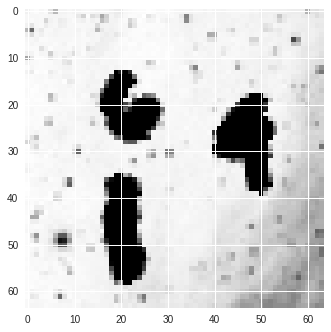

In [0]:
# function to show figures. This part has nothing to do with training.
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(x_test[100])
plt.show()

In [0]:
#*********************************************************************
# model part
import torchvision.models as models
# use pretrained model:
model = models.vgg16(pretrained = True)
#import OrderedDicted to corectly align the network layers
#import nn to modify features
from collections import OrderedDict
from torch import nn
#create classifier which fit our num of outputs
classifier= nn.Sequential(
            nn.Dropout(p = 0.5),
            nn.Linear(in_features=25088, out_features=512, bias=True),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(in_features=512, out_features=512, bias=True),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.4),
            nn.Linear(512, 10),
        )
#replace the model's classifier with this new classifier 
model.classifier = classifier

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
553433881it [00:22, 24736982.37it/s]


In [0]:
#import optimizer:
from torch import optim
#define criteria and optimizer
# Note that other losses or optimizers can also be tried
criteria = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.0003, momentum=0.9)

In [0]:
#train model
#define training function
def train (model, loader, criterion, gpu):
    model.train()
    current_loss = 0
    current_correct = 0
    for train, y_train in iter(loader):
        if gpu:
            train, y_train = train.to('cuda'), y_train.to('cuda')
        optimizer.zero_grad()
        output = model.forward(train)
        _, preds = torch.max(output,1)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        current_loss += loss.item()*train.size(0)
        current_correct += torch.sum(preds == y_train.data)
        #check if the training is correct: print(preds,y_train,current_correct,current_loss)
    epoch_loss = current_loss / len(loader)
    # devide 4 because we read 4 data everytime
    epoch_acc = current_correct.double() / len(loader)/4
        
    return epoch_loss, epoch_acc

In [0]:
#define validation function
def validation (model, loader, criterion, gpu):
    model.eval()
    valid_loss = 0
    valid_correct = 0
    #I added this
    pred=torch.zeros(len(loader))
    for valid, y_valid in iter(loader):
        if gpu:
            valid, y_valid = valid.to('cuda'), y_valid.to('cuda')
        output = model.forward(valid)
        _, preds = torch.max(output,1)
        valid_loss += criterion(output, y_valid).item()*valid.size(0)
        valid_correct += torch.sum(preds == y_valid.data)
    
    epoch_loss = valid_loss / len(loader)
    epoch_acc = valid_correct.double() / len(loader)/4
    
    return epoch_loss, epoch_acc

In [0]:
#define test function
def test (model, loader, criterion, gpu):
    model.eval()
    valid_loss = 0
    valid_correct = 0
    i=0
    pred=torch.zeros(len(loader))
    for test, y_train in iter(loader):
        if gpu:
            test = test.to('cuda')
        output = model.forward(test)
        _, preds = torch.max(output,1)
        pred[i]=preds
        i=i+1    
    return pred

In [14]:
# training
#send model to gpu. If not send it to GPU, delete next line.
model.to('cuda')
train_losses =[]
train_acc =[]
valid_losses=[]
valid_acc =[]
#Initialize training params  
#freeze gradient parameters in pretrained model
for param in model.parameters():
    param.require_grad = False
# define number of epochs
epochs = 16 
epoch = 0

for e in range(epochs):
    epoch +=1
    print(epoch)
#train:    
    with torch.set_grad_enabled(True):
        epoch_train_loss, epoch_train_acc = train(model,trainloader, criteria, 1)
        train_losses.append(epoch_train_loss)
        train_acc.append(epoch_train_acc)
    print("Epoch: {} Train Loss : {:.4f}  Train Accuracy: {:.4f}".format(epoch,epoch_train_loss,epoch_train_acc))
    
#Valid, Activate next code when validation result is needed:
    with torch.no_grad():
        epoch_val_loss, epoch_val_acc = validation(model, validloader, criteria, 1)
        valid_losses.append(epoch_val_loss)
        valid_acc.append(epoch_val_acc)
    print("Epoch: {} Validation Loss : {:.4f}  Validation Accuracy {:.4f}".format(epoch,epoch_val_loss,epoch_val_acc))

1
Epoch: 1 Train Loss : 8.1799  Train Accuracy: 0.2437
Epoch: 1 Validation Loss : 3.4209  Validation Accuracy 0.7460
2
Epoch: 2 Train Loss : 2.8490  Train Accuracy: 0.8072
Epoch: 2 Validation Loss : 1.3136  Validation Accuracy 0.9138
3
Epoch: 3 Train Loss : 1.5891  Train Accuracy: 0.9019
Epoch: 3 Validation Loss : 0.9042  Validation Accuracy 0.9307
4
Epoch: 4 Train Loss : 1.1779  Train Accuracy: 0.9296
Epoch: 4 Validation Loss : 0.6953  Validation Accuracy 0.9485
5
Epoch: 5 Train Loss : 0.9174  Train Accuracy: 0.9459
Epoch: 5 Validation Loss : 0.5778  Validation Accuracy 0.9610
6
Epoch: 6 Train Loss : 0.7540  Train Accuracy: 0.9549
Epoch: 6 Validation Loss : 0.4593  Validation Accuracy 0.9663
7
Epoch: 7 Train Loss : 0.6043  Train Accuracy: 0.9641
Epoch: 7 Validation Loss : 0.5099  Validation Accuracy 0.9605
8
Epoch: 8 Train Loss : 0.5402  Train Accuracy: 0.9676
Epoch: 8 Validation Loss : 0.4971  Validation Accuracy 0.9665
9
Epoch: 9 Train Loss : 0.4438  Train Accuracy: 0.9746
Epoch: 9 

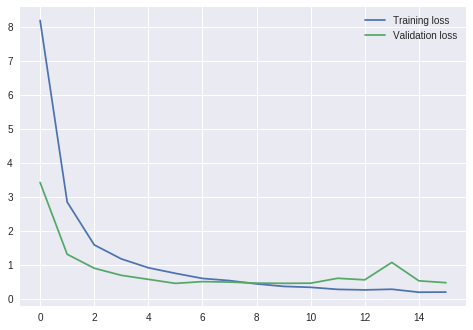

In [15]:
#Plot training and validation losses
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend()

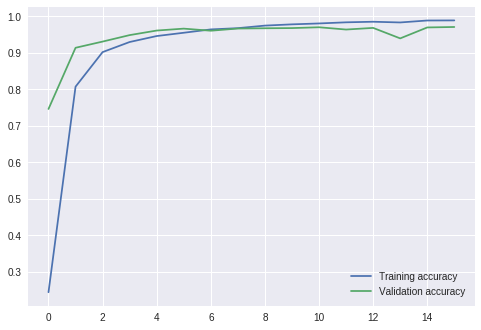

In [16]:
#Plot training and validation accuracy
plt.plot(train_acc, label='Training accuracy')
plt.plot(valid_acc, label='Validation accuracy')
plt.legend()

In [17]:
# for variety, lets use altair to do the plot
import altair as alt

# create a pandas dataframe for the loss
df = pd.DataFrame({
    'epoch': range(1, len(train_losses) + 1),
    'train': train_losses,
    'valid': valid_losses
})

# unpivot to have cols [epoch, dataset, loss]
df = df.melt(id_vars=['epoch'],
             value_vars=['train', 'valid'],
             value_name='loss',
             var_name='Dataset')

# line plot with altair
alt.Chart(df).mark_line(point=True)\
    .encode(x='epoch', y='loss', color='Dataset')\
    .interactive()

Chart({
  data:     epoch Dataset      loss
  0       1   train  8.179914
  1       2   train  2.848992
  2       3   train  1.589077
  3       4   train  1.177934
  4       5   train  0.917396
  5       6   train  0.753998
  6       7   train  0.604332
  7       8   train  0.540194
  8       9   train  0.443753
  9      10   train  0.370702
  10     11   train  0.343187
  11     12   train  0.282890
  12     13   train  0.267406
  13     14   train  0.286918
  14     15   train  0.199622
  15     16   train  0.203482
  16      1   valid  3.420920
  17      2   valid  1.313574
  18      3   valid  0.904171
  19      4   valid  0.695258
  20      5   valid  0.577752
  21      6   valid  0.459309
  22      7   valid  0.509920
  23      8   valid  0.497065
  24      9   valid  0.466548
  25     10   valid  0.460384
  26     11   valid  0.464183
  27     12   valid  0.608310
  28     13   valid  0.563163
  29     14   valid  1.074519
  30     15   valid  0.533269
  31     16   valid  0.479253,
  encoding: EncodingWithFacet({
    color: Color({
      shorthand: 'Dataset'
    }),
    x: X({
      shorthand: 'epoch'
    }),
    y: Y({
      shorthand: 'loss'
    })
  }),
  mark: MarkDef({
    point: True,
    type: 'line'
  }),
  selection: SelectionMapping({
    selector001: SelectionDef({
      bind: 'scales',
      encodings: ['x', 'y'],
      type: 'interval'
    })
  })
})

In [0]:
#get prediction result for test data
predict=test(model,testloader, criteria, 1)
result=predict.numpy()

In [0]:
# Put data in the appropriate format for kaggle submissiom
submission = pd.DataFrame()

In [0]:
a = result.astype(int)
df1 = pd.DataFrame({'Id': a})

In [21]:
submission['Id']=range(0, len(df1) )

submission['Category']=a
submission.head()

,Id,Category
0,0,7
1,1,1
2,2,6
3,3,1
4,4,8


In [0]:
submission.to_csv('vgg16_.csv', index=False)

In [0]:
from google.colab import files
files.download('vgg16_.csv') 